## Configuration of a simulation case (*caseExample*)

### Importing required libraries

Some of these are well known libraries such as *numpy* and *matplotlib* (they can be installed using pip). We also need to import the library *utils* containing predefined functionalities for this software. 

In [14]:
import os
import math                    
import numpy as np             
import matplotlib.pyplot as plt 
import re
from glob import glob
from utils import modify_header_file,write_config,write_initial,write_equilibrium,backup_file,restore_file,compile_program,run_program,initialize_variables,read_data_euler

### Setting up the paths

First, the name of the folder for this test case must be specified:

In [15]:
#This test case will run in the folder "caseExample/". 
#Don't forget the bar (/). 
#This directory should have been created prior to the execution to this script, and should also contain an /out folder inside
folder_case="caseExample/" 

Then, all the paths are automatically assigned:

In [16]:
#Do not modify the folders and paths below
script_dir = os.getcwd()
folder_out="out/"
folder_lib="lib"
fname_config="configure.input"
fname_eq="equilibrium.out"
fname_ini="initial.out"
folder_out = os.path.join(script_dir, "../"+folder_case+"/"+folder_out)
folder_case = os.path.join(script_dir, "../"+folder_case)
folder_lib = os.path.join(script_dir, "../"+folder_lib)
folder_exe = os.path.join(script_dir, "../")

### Setting up the compilation variables (*definitions.h*)

Here, we can modify those variables that need to be set before compilation and are found in the file *definitions.h*. Don't worry if you mess up things here, a backup of the original file is created before modification and will be restored at the end of this script, after compilation and execution.

In [17]:
#Do not change the line below, it creates a backup of the definitions.h file
backup_file(folder_lib+'/definitions.h')
#Configure the header file for compilation. Add as many lines as desired for the macros you want to modify.
modify_header_file(folder_lib+'/definitions.h', 'NTRHEADS', 2)         #number of threads
modify_header_file(folder_lib+'/definitions.h', 'EQUATION_SYSTEM', 2)  #System of equations solved
modify_header_file(folder_lib+'/definitions.h', 'ST', 3)               #Source term type
modify_header_file(folder_lib+'/definitions.h', 'SOLVER', 0)           #Riemann solver used
modify_header_file(folder_lib+'/definitions.h', 'READ_INITIAL', 1)     #Read or not initial data, this should ALWAYS be 1

Backup created at C:\Users\sie2016\EHOW3D_07_2024\python\../lib/definitions.h.bak
NTRHEADS changed to 2 in C:\Users\sie2016\EHOW3D_07_2024\python\../lib/definitions.h
EQUATION_SYSTEM changed to 2 in C:\Users\sie2016\EHOW3D_07_2024\python\../lib/definitions.h
ST changed to 3 in C:\Users\sie2016\EHOW3D_07_2024\python\../lib/definitions.h
SOLVER changed to 0 in C:\Users\sie2016\EHOW3D_07_2024\python\../lib/definitions.h
READ_INITIAL changed to 1 in C:\Users\sie2016\EHOW3D_07_2024\python\../lib/definitions.h


### Configure the global simulation parameters

We can set the global simulation parameters as desired:

In [18]:
#Simulation setup
FinalTime = 800.0
DumpTime = 100.0  #for file printing
CFL = 0.45
Order = 7

#Mesh setup
xcells = 100
ycells = 1
zcells = 50
SizeX = 20000.0
SizeY = 1000.0
SizeZ = 10000.0

#Boundary conditions
Face_1 = 4 #-y
Face_2 = 4 #+x
Face_3 = 4 #+y
Face_4 = 4 #-x
Face_5 = 4 #-z
Face_6 = 4 #+z

#Linear transport, only if applicable
u_x = 1.0
u_y = 1.0
u_z = 1.0

### Define the initial condition

To define the initial condition we first need to create the arrays and initialize some variables:

In [19]:
xc, yc, zc, u, v, w, rho, p, phi, ue, ve, we, rhoe, pe = initialize_variables(xcells, ycells, zcells, SizeX, SizeY, SizeZ)

Among these, we have:
- the problem variables: ```u, v, w, rho, p, phi```
- the equilibrium variables (for atmospheric cases): ```ue, ve, we, rhoe, pe```

Then we can set the initial condition using those variables. To do this, we loop over the three cartesian indexes $(l,m,n)$ and assign the variables, e.g. $\rho(x_l,y_m,z_n)=...$ is set as ```rho[l,m,n]=...```. Cell centers are given by: ```xc[l,m,n]```, ```yc[l,m,n]``` and ```zc[l,m,n]```.

In [20]:
#Some auxiliary parameters (must be equal to those in definitions.h)
tt0=300
p0=1.e5
R=287.058
gamma=1.4
g=9.8
rho0=p0/(R*tt0)
aux2=(gamma-1.0)/gamma*g/(R*tt0)

#Initial condition and equilibrium state            
for l in range(0,xcells): 
        for m in range(0,ycells): 
            for n in range(0,zcells):
                
                #This is the equilibrium state (in this case, adiabatic equilibrium):
                rhoe[l,m,n]=rho0*(1.0-aux2*zc[l,m,n])**(1.0/(gamma-1.0))
                pe  [l,m,n]=p0*  (1.0-aux2*zc[l,m,n])**(gamma/(gamma-1.0))
                ue  [l,m,n]=0.0
                ve  [l,m,n]=0.0
                we  [l,m,n]=0.0
                
                #This is the initial condition
                xp=10000;
                zp=2000;
                d1=np.sqrt((xc[l,m,n]-xp)*(xc[l,m,n]-xp)+(zc[l,m,n]-zp)*(zc[l,m,n]-zp));

                xp=10000;
                zp=8000;
                d2=np.sqrt((xc[l,m,n]-xp)*(xc[l,m,n]-xp)+(zc[l,m,n]-zp)*(zc[l,m,n]-zp));

                rc=1000;
                aux1=20.0*(max(rc-d1/2.0,0.0)+min(d2/2.0-rc,0.0))/1000;

                tt=tt0+aux1;
                aux2=(gamma-1.0)/gamma*g/(R*tt0);
                
                rho[l,m,n]=p0/(R*tt)*(1.0-aux2*zc[l,m,n])**(1.0/(gamma-1.0)) #density
                p  [l,m,n]=p0* (1.0-aux2*zc[l,m,n])**(gamma/(gamma-1.0)) #pressure
                u  [l,m,n]=0.0 #x-velocity
                v  [l,m,n]=0.0 #y-velocity
                w  [l,m,n]=0.0 #z-velocity
                phi[l,m,n]=0.0 #solute

Now, the configuration and initial condition (and equilibrium) files are written: 

In [21]:
write_config(folder_case, fname_config, FinalTime, DumpTime, CFL, Order, xcells, ycells, zcells, SizeX, SizeY, SizeZ, Face_1, Face_2, Face_3, Face_4, Face_5, Face_6, u_x, u_y, u_z)
write_equilibrium(folder_case, fname_eq, xcells, ycells, zcells, xc, yc, zc, ue, ve, we, rhoe, pe)       
write_initial(folder_case, fname_ini, xcells, ycells, zcells, xc, yc, zc, u, v, w, rho, p, phi)

### Compilation and execution

The program is compiled and executed:

In [22]:
compile_program()
print("Program is running...")
run_program(folder_exe+"./exehow3d "+folder_case)
restore_file(folder_lib+'/definitions.h')

Program is running...
File restored from C:\Users\sie2016\EHOW3D_07_2024\python\../lib/definitions.h.bak and backup removed


### Reading data and plotting

To read data, we use the function ```read_data_euler()``` which gives as output the numerical solution for all time levels, e.g.  $\rho(x_l,y_m,z_n,t_j)$ is ```rho[l,m,n,j]```, where ```j``` is the time level.

This can be customized for each particular case. 

['C:\\Users\\sie2016\\EHOW3D_07_2024\\python\\../caseExample//out\\list_eq.out', 'C:\\Users\\sie2016\\EHOW3D_07_2024\\python\\../caseExample//out\\state000.out', 'C:\\Users\\sie2016\\EHOW3D_07_2024\\python\\../caseExample//out\\state001.out', 'C:\\Users\\sie2016\\EHOW3D_07_2024\\python\\../caseExample//out\\state002.out', 'C:\\Users\\sie2016\\EHOW3D_07_2024\\python\\../caseExample//out\\state003.out', 'C:\\Users\\sie2016\\EHOW3D_07_2024\\python\\../caseExample//out\\state004.out', 'C:\\Users\\sie2016\\EHOW3D_07_2024\\python\\../caseExample//out\\state005.out', 'C:\\Users\\sie2016\\EHOW3D_07_2024\\python\\../caseExample//out\\state006.out', 'C:\\Users\\sie2016\\EHOW3D_07_2024\\python\\../caseExample//out\\state007.out', 'C:\\Users\\sie2016\\EHOW3D_07_2024\\python\\../caseExample//out\\state008.out']
Printing figures in folderC:\Users\sie2016\EHOW3D_07_2024\python\../caseExample//out/
C:\Users\sie2016\EHOW3D_07_2024\python\../caseExample//out\list_eq.out file read


C:\Users\sie2016\anaconda3\lib\site-packages\ipykernel_launcher.py:28: UserWarning: No contour levels were found within the data range.


C:\Users\sie2016\EHOW3D_07_2024\python\../caseExample//out\state000.out file read
C:\Users\sie2016\EHOW3D_07_2024\python\../caseExample//out\state001.out file read
C:\Users\sie2016\EHOW3D_07_2024\python\../caseExample//out\state002.out file read
C:\Users\sie2016\EHOW3D_07_2024\python\../caseExample//out\state003.out file read
C:\Users\sie2016\EHOW3D_07_2024\python\../caseExample//out\state004.out file read
C:\Users\sie2016\EHOW3D_07_2024\python\../caseExample//out\state005.out file read
C:\Users\sie2016\EHOW3D_07_2024\python\../caseExample//out\state006.out file read
C:\Users\sie2016\EHOW3D_07_2024\python\../caseExample//out\state007.out file read
C:\Users\sie2016\EHOW3D_07_2024\python\../caseExample//out\state008.out file read


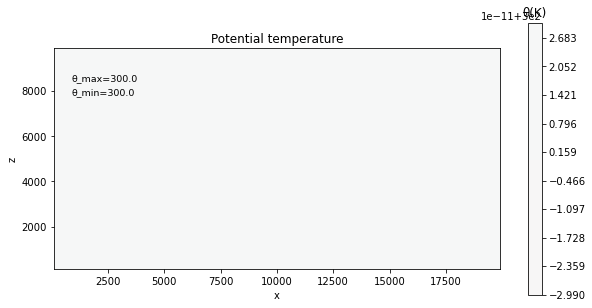

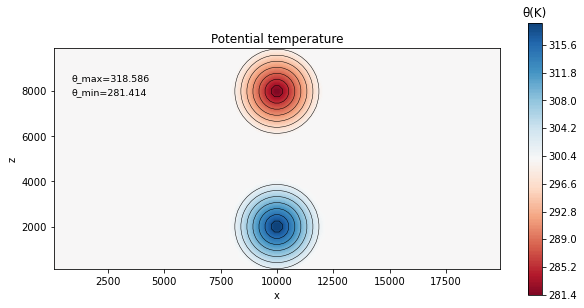

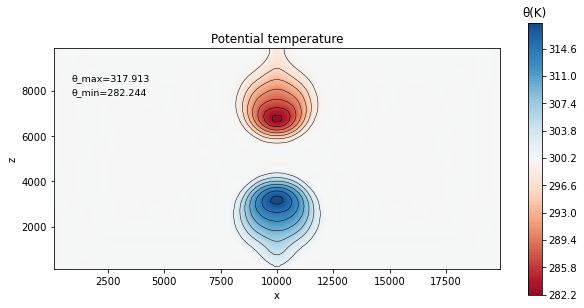

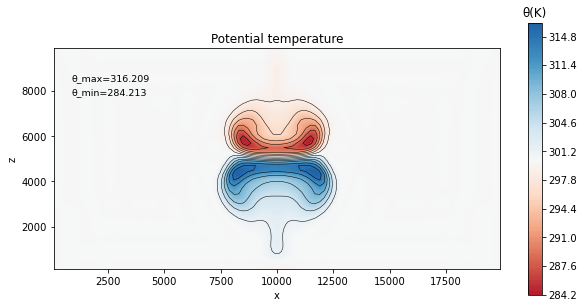

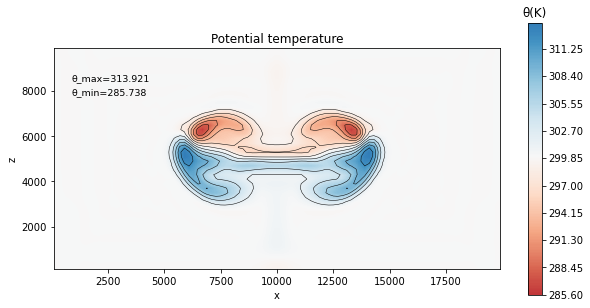

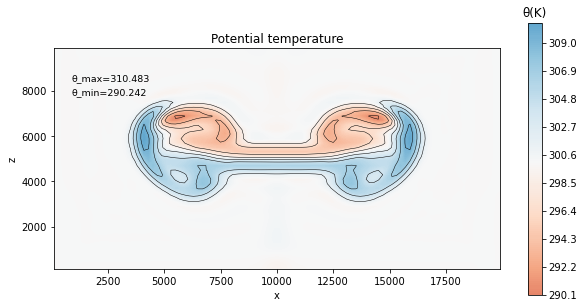

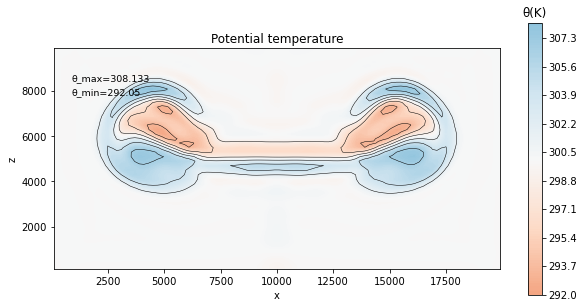

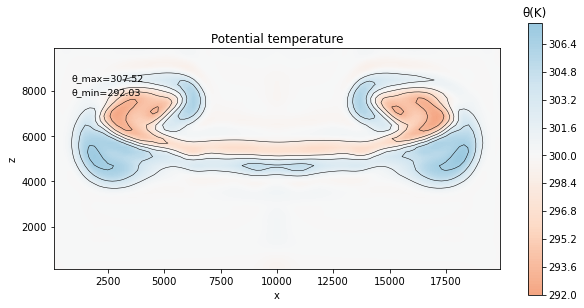

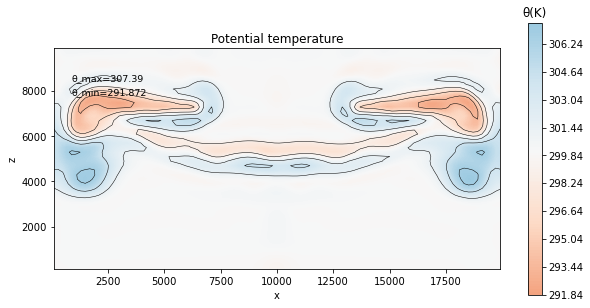

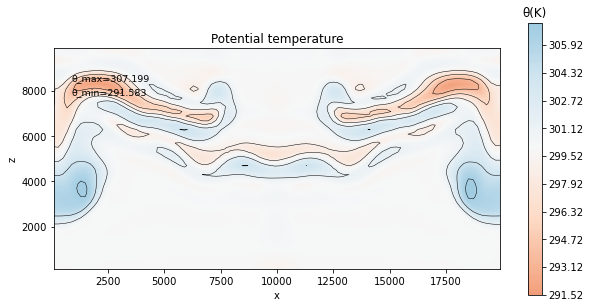

In [23]:
files = glob(folder_out+"/*.out")
lf=len(files)
print(files)

gamma=1.4
j=0
print("Printing figures in folder"+folder_out)
for fname in files:
    
    u, v, w, rho, p, phi, theta, E = read_data_euler(fname, xcells, ycells, zcells, lf, gamma, j)
                  
    filename = fname+"_theta2D"
    
    xp = xc[:,0,0]     
    zp = zc[0,0,:]      
    X, Y = np.meshgrid(xp, zp)    #matriz de puntos
    Srho=np.transpose(rho[:,0,:,j])
    Spres=np.transpose(p[:,0,:,j])
    Svel=np.transpose(np.sqrt(u[:,0,:,j]**2+w[:,0,:,j]**2))
    Senr=np.transpose(E[:,0,:,j])
    Sphi=np.transpose(phi[:,0,:,j])
    Su=np.transpose(u[:,0,:,j])
    Sth=np.transpose(theta[:,0,:,j])
    
    fig, ax = plt.subplots(figsize=(10, 5))   
    levels = np.linspace(280, 320, 16)
    #print(levels)
    plot1=ax.contour(X, Y, Sth, levels=levels,colors="k",linewidths=0.5)  
    plot1=ax.contourf(X, Y, Sth, 200, cmap='RdBu')   
    ax.set_title('Potential temperature')
    ax.set_xlabel("x") 
    ax.set_ylabel("z") 
    ax.set_aspect('equal', 'box')
    plot1.set_clim( 280, 320 )
    # Create colorbar
    cbar = plt.colorbar(plot1)
    cbar.ax.set_title('θ(K)')
    fig.text(0.15, 0.72, "θ_max="+str(round(np.max(Sth),3)), fontsize=9.5)
    fig.text(0.15, 0.68, "θ_min="+str(round(np.min(Sth),3)), fontsize=9.5)
    
    fig.savefig(filename+".png",dpi=500)
    
    j=j+1
         